In [1]:
from rasterio import rio
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import dask as da
import h5py as h5
import geopandas as gpd
import pandas as pd

# enable fiona KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# basemap
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

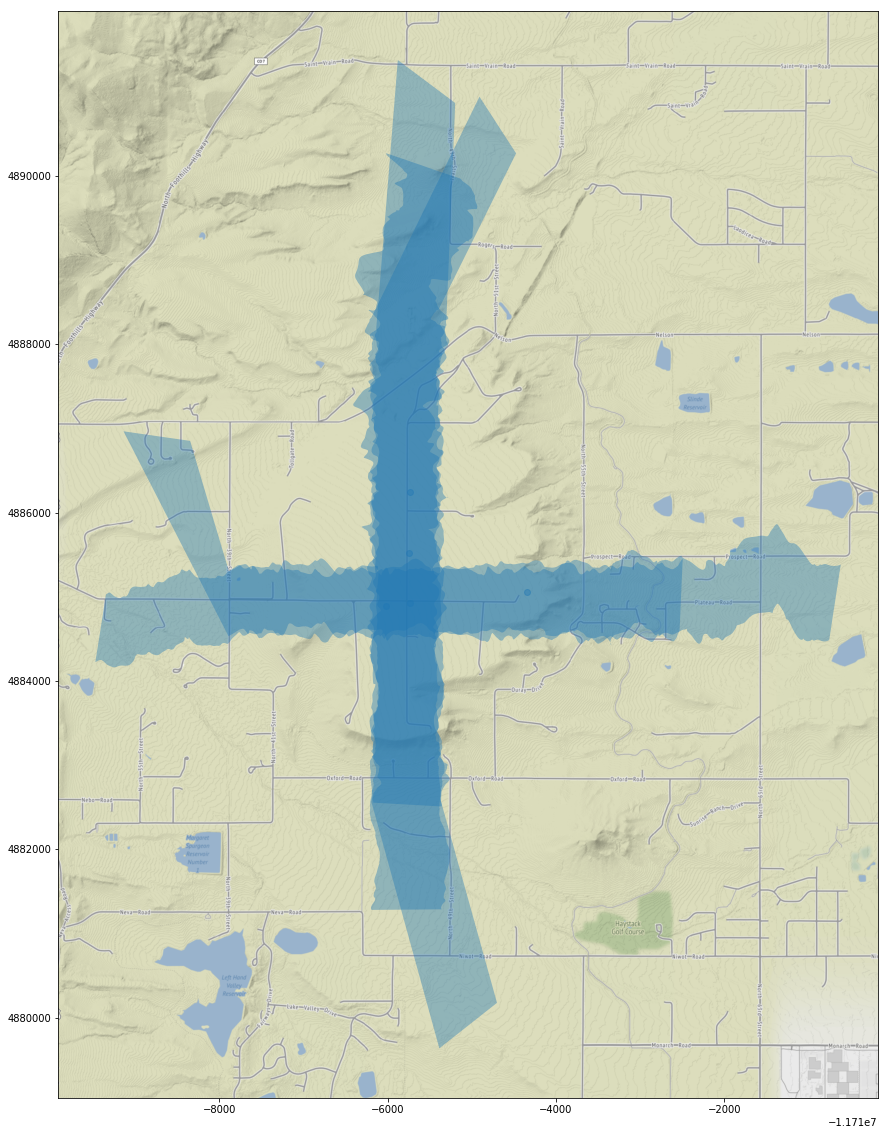

In [2]:
## plot the flightlines
flightlines = glob(r'D:\projects\headwall_neon\neon_data\2019_R10C_1\Metadata\Spectrometer\FlightlineBoundary\*.kml')
all_df = []
for f in flightlines:
    test = gpd.read_file(f).to_crs(epsg=3857)
    
    all_df.append(test)

all_df = gpd.GeoDataFrame(pd.concat(all_df, ignore_index=True), crs=all_df[0].crs)
ax = all_df.plot(figsize=(20,20), alpha=0.4)
add_basemap(ax, zoom=15)

In [3]:
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


In [4]:
## try to open one of the data files with xarray
data_file = radiance_files_april09[0]
#xarr = xr.open_dataset(data_file, 'Radiance_Data')


# Read H5 file
f = h5.File(data_file, "r")
# Get and print list of datasets within the H5 file
datasetNames = [n for n in f.keys()]
# for n in datasetNames:
#     print(n)
    
# for n in f['R10C'].keys():
#     print(n)
    
# for n in f['R10C']['Radiance'].keys():
#     print(n)
    
for n in f.keys():
    print(n)
    
    if type(f[n]) is h5._hl.group.Group:
    
        for n2 in f[n].keys():
            print('-- {}'.format(n2))

            if type(f[n][n2]) is h5._hl.group.Group:
                for n3 in f[n][n2].keys():
                    print('-- -- {}'.format(n3))

                    if type(f[n][n2][n3]) is h5._hl.group.Group:
                        for n4 in f[n][n2][n3].keys():
                            print('-- -- -- {}'.format(n4))
                            
                            if type(f[n][n2][n3][n4]) is h5._hl.group.Group:
                                for n5 in f[n][n2][n3][n4].keys():
                                    print('-- -- -- -- {}'.format(n5))
                                    
                                    if type(f[n][n2][n3][n4][n5]) is h5._hl.group.Group:
                                        for n6 in f[n][n2][n3][n4][n5].keys():
                                            print('-- -- -- -- -- {}'.format(n6))
                                            
                                            if type(f[n][n2][n3][n4][n5][n6]) is h5._hl.group.Group:
                                                for n7 in f[n][n2][n3][n4][n5][n6].keys():
                                                    print('-- -- -- -- -- {}'.format(n7))
                        


R10C
-- Radiance
-- -- Metadata
-- -- -- Ancillary_Rasters
-- -- -- -- GLT_Data
-- -- -- -- IGM_Data
-- -- -- -- OBS_Data
-- -- -- Coordinate_System
-- -- -- -- Coordinate_System_String
-- -- -- -- EPSG Code
-- -- -- -- Map_Info
-- -- -- -- Proj4
-- -- -- Flight_Trajectory
-- -- -- -- Flight_Altitude
-- -- -- -- Flight_Heading
-- -- -- -- Flight_Time
-- -- -- QAQC
-- -- -- Spectral_Data
-- -- -- -- FWHM
-- -- -- -- Wavelength
-- -- Radiance_Data


In [5]:
## metadata
# spectral
wavelength = f['R10C']['Radiance']['Metadata']['Spectral_Data']['Wavelength'][:]
fwhm = f['R10C']['Radiance']['Metadata']['Spectral_Data']['FWHM'][:]

# flight
alt = f['R10C']['Radiance']['Metadata']['Flight_Trajectory']['Flight_Altitude'][:]
heading = f['R10C']['Radiance']['Metadata']['Flight_Trajectory']['Flight_Heading'][:]
time = f['R10C']['Radiance']['Metadata']['Flight_Trajectory']['Flight_Time'][:]

# QAQC
qaqc = f['R10C']['Radiance']['Metadata']['QAQC']

# CRS
crs_str = f['R10C']['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
crs_epsg = f['R10C']['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
crs_mapinfo = f['R10C']['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
crs_proj4 = f['R10C']['Radiance']['Metadata']['Coordinate_System']['Proj4'].value
print(crs_str)
print(crs_epsg)
print(crs_mapinfo)
print(crs_proj4)

# ancillary
GLT = f['R10C']['Radiance']['Metadata']['Ancillary_Rasters']['GLT_Data'][:]
IGM = f['R10C']['Radiance']['Metadata']['Ancillary_Rasters']['IGM_Data'][:]
OBS = f['R10C']['Radiance']['Metadata']['Ancillary_Rasters']['OBS_Data'][:]
print(GLT.shape, IGM.shape, OBS.shape)

b'PROJCS["WGS_1984_UTM_Zone_13N",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-105.0],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0.0],UNIT["Meter",1.0]]'
b'32613'
b'UTM,  1.000,  1.000,  478768.000,  4444913.000,  1.0000000000e+000,  1.0000000000e+000,  13,  North,  WGS-84,  units=Meters, 0'
b'+proj=UTM +zone=  13 +ellps=  WGS-84 +datum=  WGS-84 +units=  units=Meters +no_defs'


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


(5446, 759, 2) (5446, 759, 3) (5446, 759, 10)


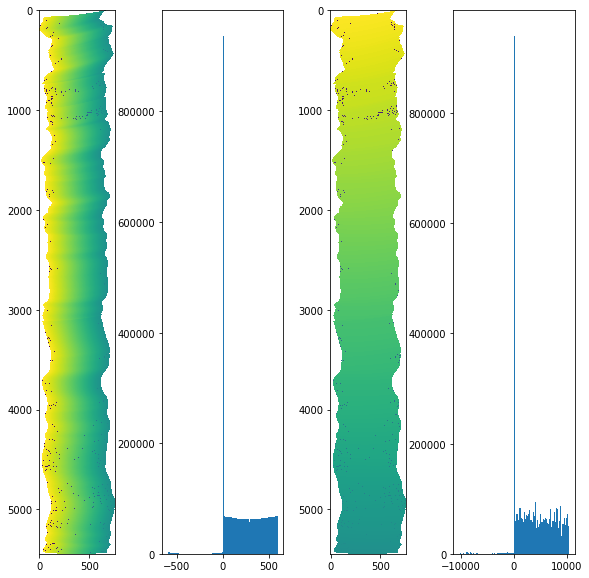

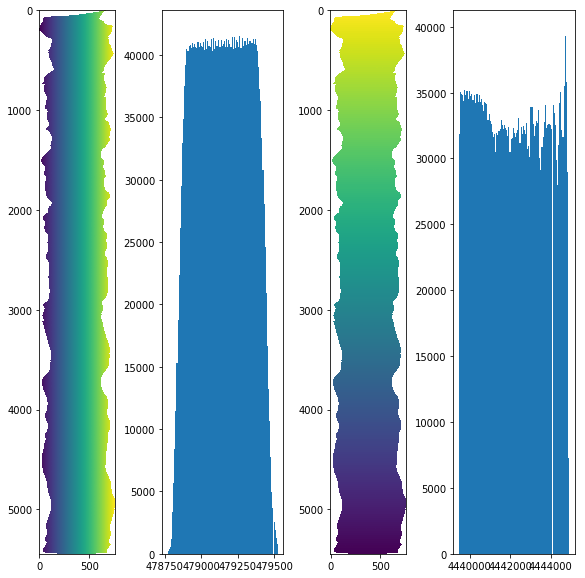

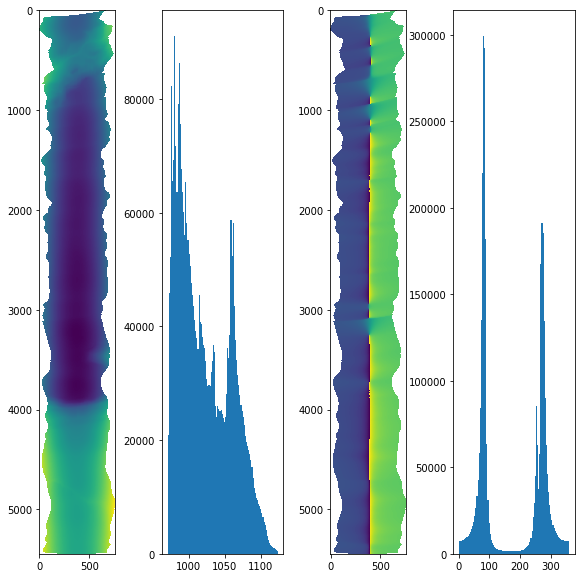

In [6]:
# GLT data
fig, ax = plt.subplots(1,4,figsize=(10,10))
plot_im = np.ma.masked_equal(GLT[:,:,0], 0)
ax[0].imshow(plot_im)
ax[1].hist(plot_im.ravel(), bins=100);
plot_im = np.ma.masked_equal(GLT[:,:,1], 0)
ax[2].imshow(plot_im)
ax[3].hist(plot_im.ravel(), bins=100);

# IGM data
fig, ax = plt.subplots(1,4,figsize=(10,10))
plot_im = np.ma.masked_equal(IGM[:,:,0], -9999)
ax[0].imshow(plot_im)
ax[1].hist(plot_im.ravel(), bins=100);
plot_im = np.ma.masked_equal(IGM[:,:,1], -9999)
ax[2].imshow(plot_im)
ax[3].hist(plot_im.ravel(), bins=100);

# OBS data
fig, ax = plt.subplots(1,4,figsize=(10,10))
plot_im = np.ma.masked_equal(OBS[:,:,0], -9999)
ax[0].imshow(plot_im)
ax[1].hist(plot_im.ravel(), bins=100);
plot_im = np.ma.masked_equal(OBS[:,:,1], -9999)
ax[2].imshow(plot_im)
ax[3].hist(plot_im.ravel(), bins=100);

In [7]:
radiance = f['R10C']['Radiance']['Radiance_Data'][:]
radiance.shape, type(radiance)

((5446, 759, 426), numpy.ndarray)

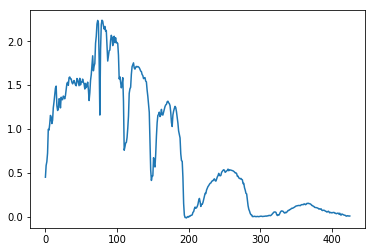

In [8]:
plt.plot(radiance[2500,350,:]);

In [9]:
mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
mapinfo = [float(a) for a in mapinfo_list[1:7]]
mapinfo
pix_size = mapinfo[0]
x = np.arange(mapinfo[2], mapinfo[2] + pix_size*radiance.shape[1], pix_size)
y = np.arange(mapinfo[3], mapinfo[3] - pix_size* radiance.shape[0], -pix_size)

In [10]:
xr_cube = xr.DataArray(radiance, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])

xr_cube_ma = xr_cube.where(xr_cube != -9999)

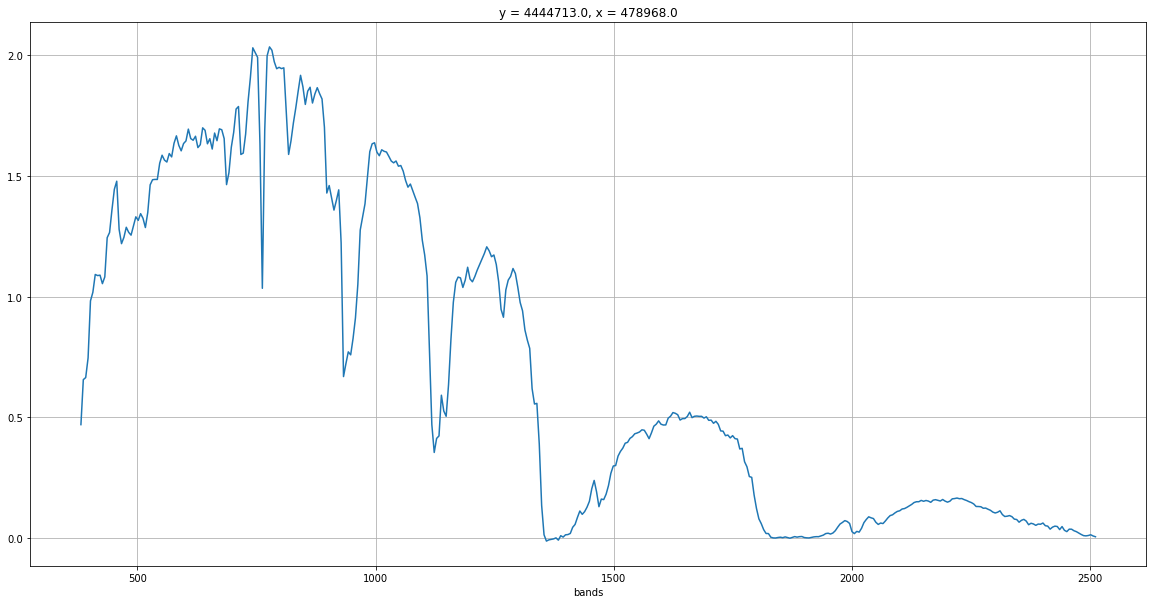

In [11]:
plt.figure(figsize=(20,10))
xr_cube_ma[200,200,:].plot()
plt.grid(True)

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


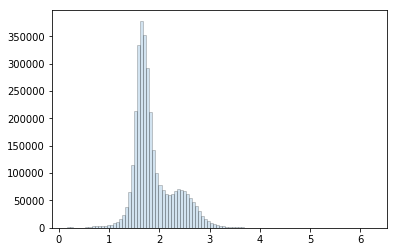

In [12]:
plt.hist(xr_cube_ma[:,:,120].values.ravel(), bins=100, alpha=0.2, edgecolor='k');

In [13]:
radiance.max()

13.176902

In [14]:
np.max(xr_cube_ma).values

array(13.176902, dtype=float32)

# Simulate a spatial extraction

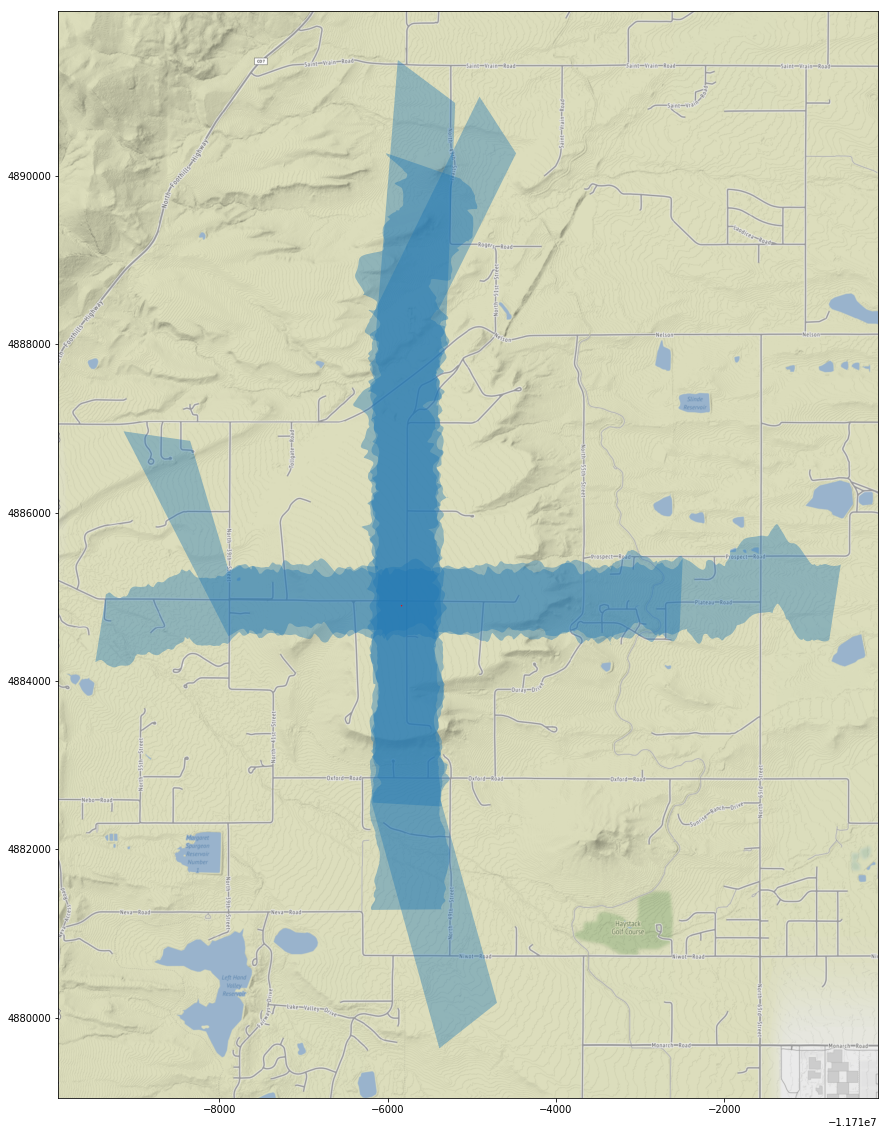

In [15]:
from shapely.geometry import Point

# cross-roads point
pt = Point(-105.24512887001036, 40.1302875511837)
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))
pt_df = pt_df.to_crs(epsg=3857).buffer(10, resolution=1)

all_df['wkt'] = [g.to_wkt() for g in all_df['geometry']]
all_df_poly = all_df[all_df['wkt'].str.match('POLY')]

ax = all_df_poly.plot(figsize=(20,20), alpha=0.4)
pt_df.plot(ax=ax, color='r')
add_basemap(ax, zoom=15)

# Create a raster mask with the point geometry


In [16]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [17]:
ds = xr.Dataset(coords={'y':y, 'x':x})
shapes = [(shape, n) for n, shape in enumerate(pt_df.to_crs(epsg=int(crs_epsg)).geometry)]
ds['aoi'] = rasterize(shapes, ds.coords)

In [18]:
ds.aoi.shape

(5446, 759)

In [19]:
# make the mask == 1
ds['aoi'] = ds.aoi +1

In [23]:
# apply the mask to the data cube
example = ds.aoi*xr_cube_ma 

In [21]:
# get the valid y and x coordinates, then reduce to unique values
val_y, val_x = np.where(ds.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)

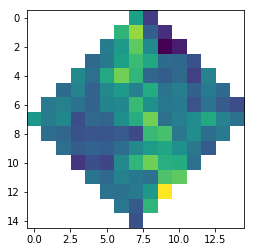

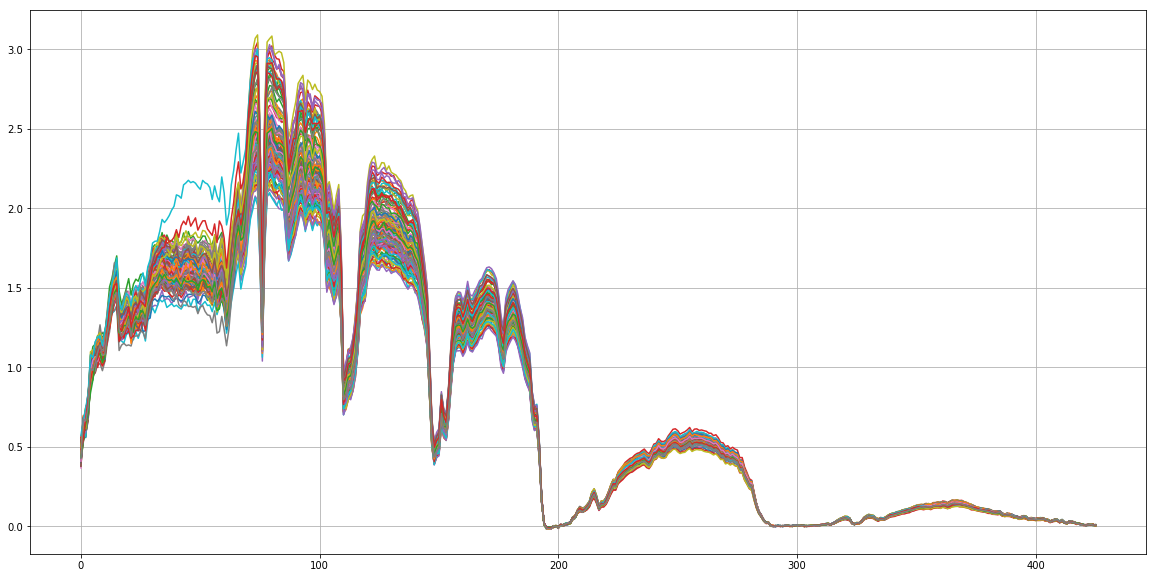

In [37]:
ex2 = example.sel(y=y[u_y], x=x[u_x])
plt.imshow(ex2[:,:,34])
plt.show()

plt.figure(figsize=(20,10))
plt.plot(ex2.values.reshape(-1, ex2.shape[-1]).T);
plt.grid(True)
plt.show()


# convert the data array to a dask array with the .chunk method

In [26]:
xr_chunks = xr_cube_ma.chunk(256)

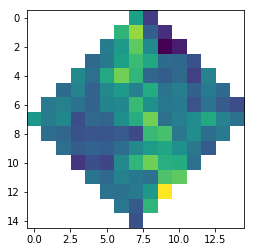

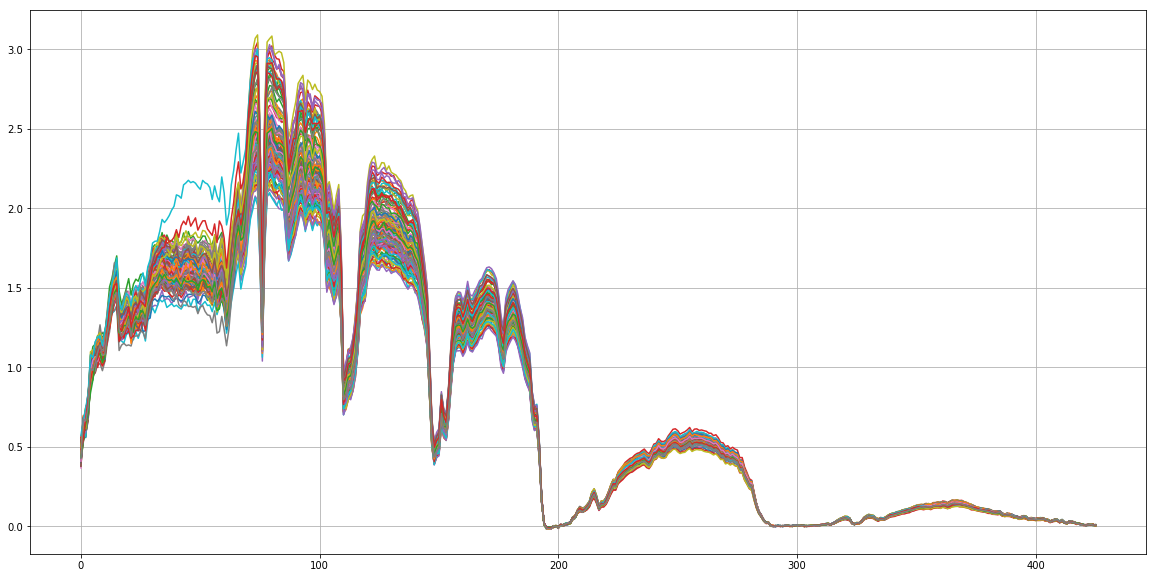

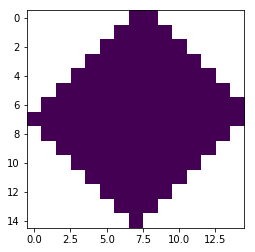

In [38]:
example = ds.aoi*xr_chunks # this seems to not mask...
ex2 = example.sel(y=y[u_y], x=x[u_x])
plt.imshow(ex2[:,:,34])
plt.show()
plt.figure(figsize=(20,10))
plt.plot(ex2.values.reshape(-1, ex2.shape[-1]).T);
plt.grid(True)
plt.show()

ex3 = ds.aoi.sel(y=y[u_y], x=x[u_x])
plt.imshow(ex3[:,:])
plt.show()
